## Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import sys
import seaborn as sns
import lightgbm as lgb
import time
from scipy import stats

/home/hello/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Reading the test and train data using pandas

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Checking "na" values
Getting the number and percent of "na" in the dataset and arranging according to percent

In [3]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(20))


total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(20))

              Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Utilities         0  0.000000
              Total   Percent
PoolQC         1456  0.997944
MiscFeature    1408  0.965045
Alley          1352  0.926662
Fence          1169  0.801234
FireplaceQu     730  0.500343
LotFrontage     227  0.155586
GarageCond       78  0.053461
GarageQual       78  0.053461
GarageYrBlt      78  0.053461
GarageFinish     78  0.053461
GarageType       76  0.052090
BsmtCond  

## Removing Prominent Outliers and Stats of Sale Price

In [4]:
train=train.drop(train.index[[523,1298]])
print(train['SalePrice'].describe())

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


## Filling the "Na" in datasets
FireplaceQU and Alley both have Dtype of string hence "na" is filled with type=string

In [5]:
train=train.drop(['PoolQC','MiscFeature','Fence'],axis=1)
test=test.drop(['PoolQC','MiscFeature','Fence'],axis=1)
train["FireplaceQu"]=train["FireplaceQu"].fillna('NoFP')
test["FireplaceQu"]=test["FireplaceQu"].fillna('NoFP')

train["Alley"]=train["Alley"].fillna('NoAlley')
test["Alley"]=test["Alley"].fillna('NoAlley')

train["GarageYrBlt"]=train["GarageYrBlt"].fillna(np.nanmedian(train["GarageYrBlt"].values))
test["GarageYrBlt"]=test["GarageYrBlt"].fillna(np.nanmedian(train["GarageYrBlt"].values))

train["MasVnrArea"]=train["MasVnrArea"].fillna(np.nanmedian(train["MasVnrArea"].values))
test["MasVnrArea"]=test["MasVnrArea"].fillna(np.nanmedian(train["MasVnrArea"].values))

train["LotFrontage"]=train["LotFrontage"].fillna(np.nanmedian(train["LotFrontage"].values))
test["LotFrontage"]=test["LotFrontage"].fillna(np.nanmedian(train["LotFrontage"].values))

test["BsmtFullBath"]=test["BsmtFullBath"].fillna(np.nanmedian(train["BsmtFullBath"].values))
test["BsmtUnfSF"]=test["BsmtUnfSF"].fillna(np.nanmedian(train["BsmtUnfSF"].values))
test["TotalBsmtSF"]=test["TotalBsmtSF"].fillna(np.nanmedian(train["TotalBsmtSF"].values))
test["GarageCars"]=test["GarageCars"].fillna(np.nanmedian(train["GarageCars"].values))
test["GarageArea"]=test["GarageArea"].fillna(np.nanmedian(train["GarageArea"].values))
test["BsmtFinSF1"]=test["BsmtFinSF1"].fillna(np.nanmedian(train["BsmtFinSF1"].values))

## Checking for skewness
Clearly visible from the below diagram that Saleprice is left skewed and hence log of values will be taken

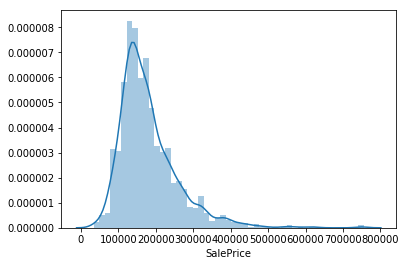

In [6]:
plt.figure();
sns.distplot(train['SalePrice']);
plt.show();

## Correlation matrix
The heatmap shows the Correlation matrix with the relations of features with each other

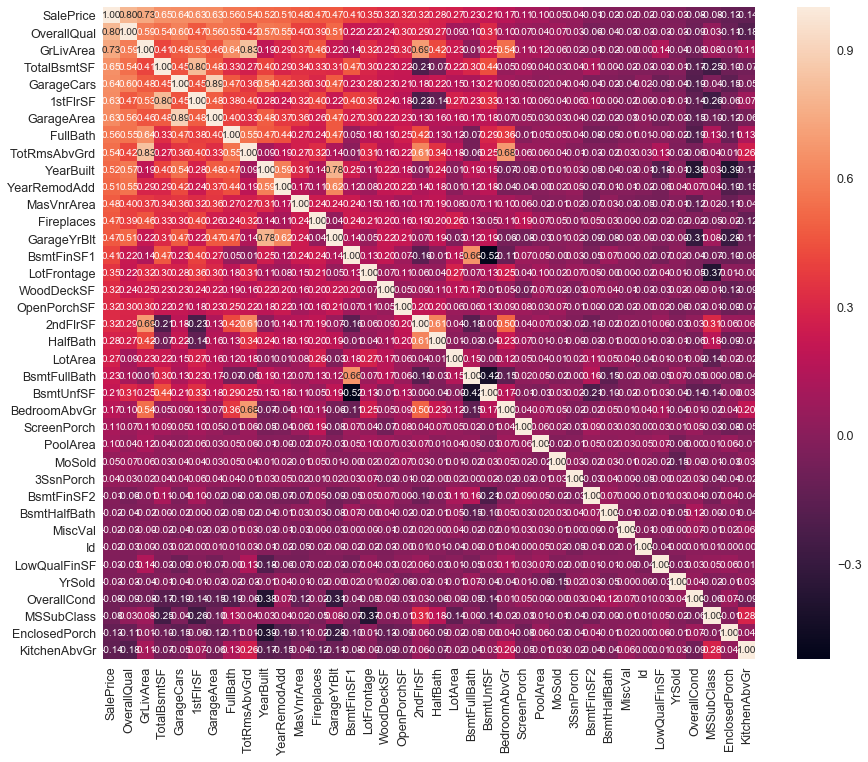

In [7]:
plt.figure();
k = 50 #number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(15, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Columns for use
Extracting only the columns needed based on values of Correlation

In [8]:
counter=0
while(cm[0][counter]>0.0900000):
    counter+=1
cols_to_use=cols[0:counter]
cols_to_use_test=cols[1:counter]

## Various Forms of Data Visualizations to understand the dataset

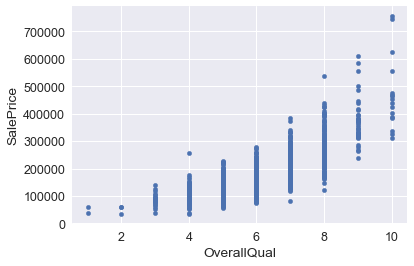

In [9]:
plt.figure(dpi=150);
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
data.plot.scatter(x='OverallQual', y='SalePrice');
plt.show();

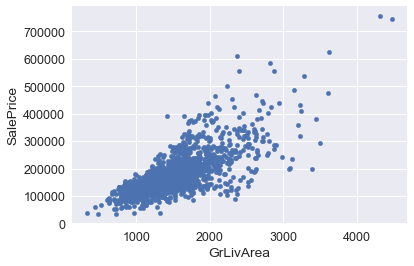

In [10]:
plt.figure();
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice');
plt.show();

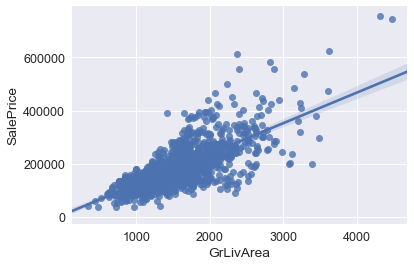

In [11]:
plt.figure();
sns.regplot(x='GrLivArea', y='SalePrice',data=data);
plt.show();

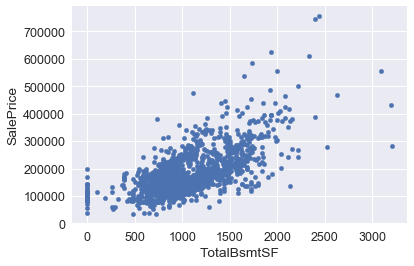

In [12]:
plt.figure();
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice');
plt.show();

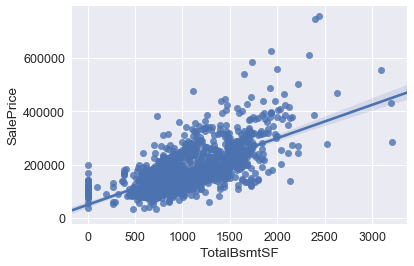

In [13]:
plt.figure()
sns.regplot(x='TotalBsmtSF', y='SalePrice',data=data);
plt.show();

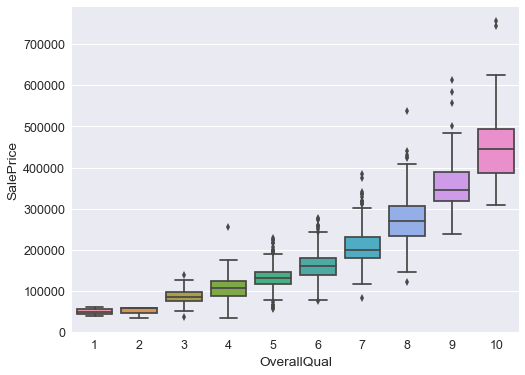

In [14]:
plt.figure();
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)
plt.show();

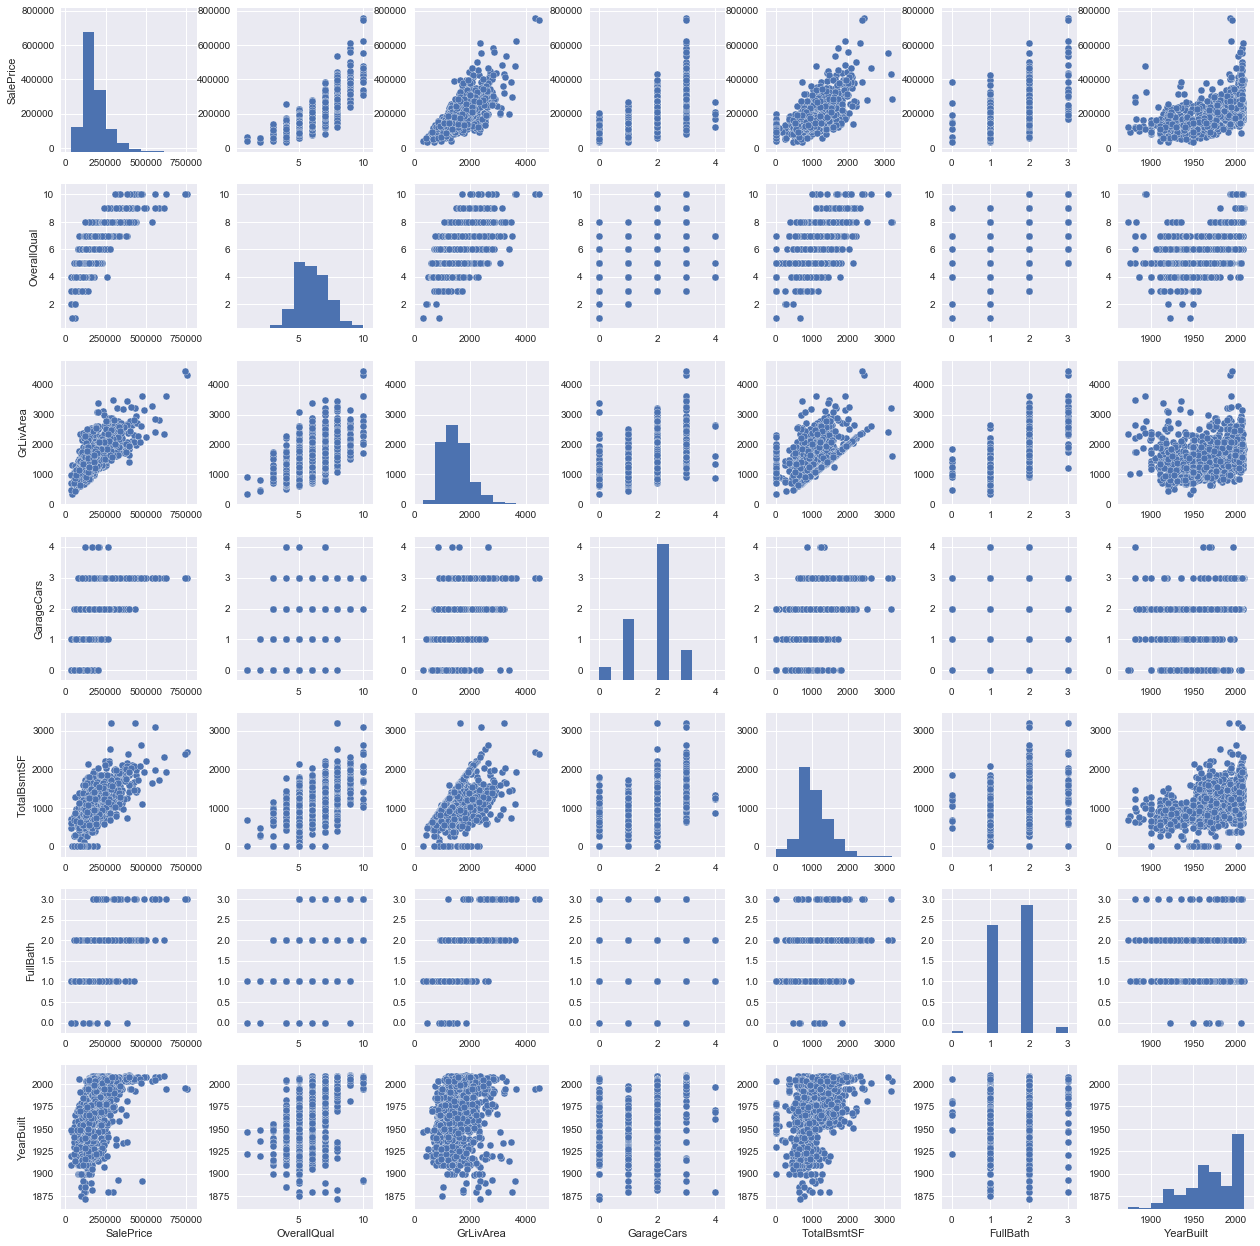

In [15]:
#scatterplot
plt.figure();
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

## Taking Log of SalePrice due to its skewness

In [16]:
train["SalePrice"] = np.log(train['SalePrice'].values)

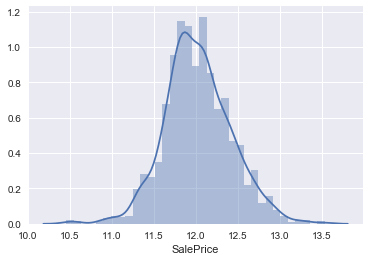

In [17]:
plt.figure();
sns.distplot(train['SalePrice']);
plt.show();

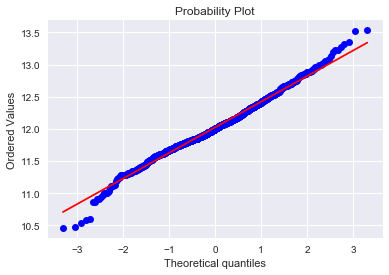

In [18]:
plt.figure();
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show();

## Extracting the necessary columns

In [19]:
train_add=pd.DataFrame()
test_add=pd.DataFrame()
for columns in test:
    if(train.loc[:,columns].dtype=='object'):
        train_add=pd.concat([train_add,train.loc[:,columns]],axis=1)
        test_add=pd.concat([test_add,test.loc[:,columns]],axis=1)
IDs=test["Id"]
IDs=IDs.values
train=train[cols_to_use]
test=test[cols_to_use_test]
train.head()

,SalePrice,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,1stFlrSF,GarageArea,FullBath,TotRmsAbvGrd,YearBuilt,...,WoodDeckSF,OpenPorchSF,2ndFlrSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch,PoolArea
0,12.247694,7,1710,856,2,856,548,2,8,2003,...,0,61,854,1,8450,1,150,3,0,0
1,12.109011,6,1262,1262,2,1262,460,2,6,1976,...,298,0,0,0,9600,0,284,3,0,0
2,12.317167,7,1786,920,2,920,608,2,6,2001,...,0,42,866,1,11250,1,434,3,0,0
3,11.849398,7,1717,756,3,961,642,1,7,1915,...,0,35,756,0,9550,1,540,3,0,0
4,12.429216,8,2198,1145,3,1145,836,2,9,2000,...,192,84,1053,1,14260,1,490,4,0,0


## Using Preprocessing Label Encoder

In [20]:
for column_index in range(0,test_add.shape[1]):
    if(train_add.iloc[:,column_index].dtype=='object'):
        #print(train.iloc[:,column_index])
        train_add.iloc[:,column_index]=train_add.iloc[:,column_index].fillna(train_add.iloc[0,column_index])
        test_add.iloc[:,column_index]=test_add.iloc[:,column_index].fillna(test_add.iloc[0,column_index])
        le.fit(list(train_add.iloc[:,column_index].values) + list(test_add.iloc[:,column_index].values)) 
        train_add.iloc[:,column_index] = le.transform(train_add.iloc[:,column_index])
        test_add.iloc[:,column_index] = le.transform(test_add.iloc[:,column_index])

In [21]:
train=pd.concat([train,train_add],axis=1)
test=pd.concat([test,test_add],axis=1)
train.head()

,SalePrice,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,1stFlrSF,GarageArea,FullBath,TotRmsAbvGrd,YearBuilt,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,12.247694,7,1710,856,2,856,548,2,8,2003,...,2,6,3,1,1,4,4,2,8,4
1,12.109011,6,1262,1262,2,1262,460,2,6,1976,...,3,6,5,1,1,4,4,2,8,4
2,12.317167,7,1786,920,2,920,608,2,6,2001,...,2,6,5,1,1,4,4,2,8,4
3,11.849398,7,1717,756,3,961,642,1,7,1915,...,2,6,2,5,2,4,4,2,8,0
4,12.429216,8,2198,1145,3,1145,836,2,9,2000,...,2,6,5,1,1,4,4,2,8,4


In [22]:
test.head()

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,1stFlrSF,GarageArea,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,5,896,882.0,1.0,896,730.0,1,5,1961,1961,...,3,6,3,1,2,4,4,2,8,4
1,6,1329,1329.0,1.0,1329,312.0,1,6,1958,1958,...,2,6,3,1,2,4,4,2,8,4
2,5,1629,928.0,2.0,928,482.0,2,6,1997,1998,...,3,6,5,1,0,4,4,2,8,4
3,6,1604,926.0,2.0,926,470.0,2,7,1998,1998,...,2,6,2,1,0,4,4,2,8,4
4,8,1280,1280.0,2.0,1280,506.0,2,5,1992,1992,...,2,6,3,1,1,4,4,2,8,4


## LightGBM
Using early stopping round method to check for best iteration to get better results which do not over-fit the Dataset.

In [23]:
y_train = train["SalePrice"]
#y_mean = np.mean(y_train)
dtrain_all= lgb.Dataset(train.drop('SalePrice', axis=1),train['SalePrice'])
dtrain=lgb.Dataset(train.drop('SalePrice', axis=1).iloc[0:1070,:],train['SalePrice'].iloc[0:1070])
dval=lgb.Dataset(train.drop('SalePrice', axis=1).iloc[1070:,:],train['SalePrice'].iloc[1070:],reference=dtrain)
dtest=lgb.Dataset(test)

params = {
    
    'num_leaves' : 12,
    'learning_rate':0.001,
    'max_bin':55,
    #'n_estimators':720,
    'objective':'regression',
    'min_data_in_leaf':6,
    'min_sum_hessian_in_leaf':12,
    'metric': {'l2', 'val'},
    'bagging_fraction':0.8,
    'feature_fraction':0.2319,
    'bagging_seed':9,
    'feature_fraction_seed':9,
}
#clf=model_lgb.train(dtrain_all)
clf_partial=lgb.train(params,dtrain,30000,dval,verbose_eval=20,early_stopping_rounds=10)
num_boost_round=clf_partial.best_iteration
clf = lgb.train(params, dtrain_all,num_boost_round=num_boost_round,verbose_eval=20)
preds = clf.predict(test)
preds_train=clf.predict(train.drop('SalePrice', axis=1))
print(r2_score(dtrain_all.get_label(), preds_train))
preds=np.exp(preds)

sub = pd.DataFrame({'Id':IDs, 'SalePrice':preds})
sub.to_csv('answer_lgb.csv', index=False)

Train until valid scores didn't improve in 10 rounds.
[20]	valid_0's l2: 0.139819
[40]	valid_0's l2: 0.13615
[60]	valid_0's l2: 0.132586
[80]	valid_0's l2: 0.129101
[100]	valid_0's l2: 0.125672
[120]	valid_0's l2: 0.122482
[140]	valid_0's l2: 0.119313
[160]	valid_0's l2: 0.116255
[180]	valid_0's l2: 0.113305
[200]	valid_0's l2: 0.11044
[220]	valid_0's l2: 0.107677
[240]	valid_0's l2: 0.104926
[260]	valid_0's l2: 0.102342
[280]	valid_0's l2: 0.0998703
[300]	valid_0's l2: 0.0974268
[320]	valid_0's l2: 0.0950239
[340]	valid_0's l2: 0.0927576
[360]	valid_0's l2: 0.0905419
[380]	valid_0's l2: 0.0884151
[400]	valid_0's l2: 0.0863662
[420]	valid_0's l2: 0.0843889
[440]	valid_0's l2: 0.0823754
[460]	valid_0's l2: 0.0804781
[480]	valid_0's l2: 0.0785714
[500]	valid_0's l2: 0.0766969
[520]	valid_0's l2: 0.0750171
[540]	valid_0's l2: 0.0733398
[560]	valid_0's l2: 0.071719
[580]	valid_0's l2: 0.0701158
[600]	valid_0's l2: 0.0686045
[620]	valid_0's l2: 0.0671646
[640]	valid_0's l2: 0.065722
[660]	v

[5440]	valid_0's l2: 0.0149391
[5460]	valid_0's l2: 0.014928
[5480]	valid_0's l2: 0.0149181
[5500]	valid_0's l2: 0.0149077
[5520]	valid_0's l2: 0.0148989
[5540]	valid_0's l2: 0.0148871
[5560]	valid_0's l2: 0.01488
[5580]	valid_0's l2: 0.0148689
[5600]	valid_0's l2: 0.0148605
[5620]	valid_0's l2: 0.0148528
[5640]	valid_0's l2: 0.0148393
[5660]	valid_0's l2: 0.0148312
[5680]	valid_0's l2: 0.0148245
[5700]	valid_0's l2: 0.0148123
[5720]	valid_0's l2: 0.0148026
[5740]	valid_0's l2: 0.0147932
[5760]	valid_0's l2: 0.0147851
[5780]	valid_0's l2: 0.014777
[5800]	valid_0's l2: 0.0147688
[5820]	valid_0's l2: 0.0147598
[5840]	valid_0's l2: 0.014752
[5860]	valid_0's l2: 0.0147434
[5880]	valid_0's l2: 0.0147333
[5900]	valid_0's l2: 0.0147244
[5920]	valid_0's l2: 0.0147167
[5940]	valid_0's l2: 0.0147089
[5960]	valid_0's l2: 0.0147027
[5980]	valid_0's l2: 0.0146925
[6000]	valid_0's l2: 0.0146821
[6020]	valid_0's l2: 0.0146746
[6040]	valid_0's l2: 0.014666
[6060]	valid_0's l2: 0.0146559
[6080]	valid_0

## XGBoost
Using a similar method as above with a partial classifier to get better results.

In [24]:
xgb_params = {
    'eta': 0.0007,
    'max_depth': 16,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    #'base_score':y_mean,
    'silent': 1
}


dtrain = xgb.DMatrix(train.drop('SalePrice', axis=1).iloc[0:1070,:], y_train.iloc[0:1070])
dtest = xgb.DMatrix(test)
dval = xgb.DMatrix(train.drop('SalePrice', axis=1).iloc[1070:,:], y_train.iloc[1070:])
dtrain_all=dtrain = xgb.DMatrix(train.drop('SalePrice', axis=1), y_train)

partial_model = xgb.train(xgb_params, dtrain_all, num_boost_round=60000, evals=[(dval, 'val')],
                       early_stopping_rounds=100, verbose_eval=20)

num_boost_round = partial_model.best_iteration

model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

print(r2_score(dtrain_all.get_label(), model.predict(dtrain_all)))
y_pred = model.predict(dtest)
y_pred = np.exp(y_pred)
output = pd.DataFrame({'Id': IDs, 'SalePrice': y_pred})
output.to_csv('xgboost-housingPrices.csv'.format(xgb_params['max_depth']), index=False)

[0]	val-rmse:11.5126
Will train until val-rmse hasn't improved in 100 rounds.
[20]	val-rmse:11.3526
[40]	val-rmse:11.1949
[60]	val-rmse:11.0394
[80]	val-rmse:10.886
[100]	val-rmse:10.7347
[120]	val-rmse:10.5856
[140]	val-rmse:10.4386
[160]	val-rmse:10.2935
[180]	val-rmse:10.1506
[200]	val-rmse:10.0097
[220]	val-rmse:9.87079
[240]	val-rmse:9.73377
[260]	val-rmse:9.59868
[280]	val-rmse:9.46545
[300]	val-rmse:9.33408
[320]	val-rmse:9.20452
[340]	val-rmse:9.07679
[360]	val-rmse:8.95081
[380]	val-rmse:8.82657
[400]	val-rmse:8.70406
[420]	val-rmse:8.58327
[440]	val-rmse:8.46414
[460]	val-rmse:8.34669
[480]	val-rmse:8.23086
[500]	val-rmse:8.11666
[520]	val-rmse:8.00404
[540]	val-rmse:7.89296
[560]	val-rmse:7.78343
[580]	val-rmse:7.67545
[600]	val-rmse:7.56895
[620]	val-rmse:7.46393
[640]	val-rmse:7.36037
[660]	val-rmse:7.25823
[680]	val-rmse:7.15751
[700]	val-rmse:7.05817
[720]	val-rmse:6.96023
[740]	val-rmse:6.86365
[760]	val-rmse:6.76841
[780]	val-rmse:6.67449
[800]	val-rmse:6.58188
[820]	v

[6740]	val-rmse:0.129414
[6760]	val-rmse:0.127928
[6780]	val-rmse:0.126454
[6800]	val-rmse:0.125
[6820]	val-rmse:0.123576
[6840]	val-rmse:0.122163
[6860]	val-rmse:0.120771
[6880]	val-rmse:0.11939
[6900]	val-rmse:0.11803
[6920]	val-rmse:0.11669
[6940]	val-rmse:0.115367
[6960]	val-rmse:0.114056
[6980]	val-rmse:0.112767
[7000]	val-rmse:0.111494
[7020]	val-rmse:0.11024
[7040]	val-rmse:0.108992
[7060]	val-rmse:0.107764
[7080]	val-rmse:0.106554
[7100]	val-rmse:0.105345
[7120]	val-rmse:0.10416
[7140]	val-rmse:0.10299
[7160]	val-rmse:0.101842
[7180]	val-rmse:0.100696
[7200]	val-rmse:0.099573
[7220]	val-rmse:0.098465
[7240]	val-rmse:0.09737
[7260]	val-rmse:0.096288
[7280]	val-rmse:0.095221
[7300]	val-rmse:0.094164
[7320]	val-rmse:0.093114
[7340]	val-rmse:0.092081
[7360]	val-rmse:0.09106
[7380]	val-rmse:0.090051
[7400]	val-rmse:0.089058
[7420]	val-rmse:0.088073
[7440]	val-rmse:0.087098
[7460]	val-rmse:0.086134
[7480]	val-rmse:0.085183
[7500]	val-rmse:0.084251
[7520]	val-rmse:0.08332
[7540]	val-r

[13200]	val-rmse:0.006351
[13220]	val-rmse:0.006308
[13240]	val-rmse:0.006268
[13260]	val-rmse:0.006225
[13280]	val-rmse:0.006184
[13300]	val-rmse:0.006139
[13320]	val-rmse:0.006095
[13340]	val-rmse:0.006054
[13360]	val-rmse:0.006018
[13380]	val-rmse:0.005979
[13400]	val-rmse:0.005943
[13420]	val-rmse:0.005904
[13440]	val-rmse:0.005865
[13460]	val-rmse:0.005827
[13480]	val-rmse:0.005788
[13500]	val-rmse:0.005752
[13520]	val-rmse:0.005714
[13540]	val-rmse:0.005677
[13560]	val-rmse:0.005644
[13580]	val-rmse:0.005609
[13600]	val-rmse:0.005576
[13620]	val-rmse:0.005541
[13640]	val-rmse:0.005505
[13660]	val-rmse:0.00547
[13680]	val-rmse:0.005437
[13700]	val-rmse:0.005404
[13720]	val-rmse:0.005374
[13740]	val-rmse:0.005338
[13760]	val-rmse:0.005305
[13780]	val-rmse:0.005271
[13800]	val-rmse:0.005239
[13820]	val-rmse:0.005208
[13840]	val-rmse:0.005175
[13860]	val-rmse:0.005146
[13880]	val-rmse:0.005116
[13900]	val-rmse:0.005083
[13920]	val-rmse:0.005051
[13940]	val-rmse:0.00502
[13960]	val-rm

[19540]	val-rmse:0.001808
[19560]	val-rmse:0.001805
[19580]	val-rmse:0.001802
[19600]	val-rmse:0.001799
[19620]	val-rmse:0.001796
[19640]	val-rmse:0.001794
[19660]	val-rmse:0.001791
[19680]	val-rmse:0.001788
[19700]	val-rmse:0.001785
[19720]	val-rmse:0.001782
[19740]	val-rmse:0.001779
[19760]	val-rmse:0.001777
[19780]	val-rmse:0.001774
[19800]	val-rmse:0.001772
[19820]	val-rmse:0.001769
[19840]	val-rmse:0.001766
[19860]	val-rmse:0.001764
[19880]	val-rmse:0.001762
[19900]	val-rmse:0.00176
[19920]	val-rmse:0.001757
[19940]	val-rmse:0.001755
[19960]	val-rmse:0.001752
[19980]	val-rmse:0.00175
[20000]	val-rmse:0.001748
[20020]	val-rmse:0.001745
[20040]	val-rmse:0.001743
[20060]	val-rmse:0.001741
[20080]	val-rmse:0.001739
[20100]	val-rmse:0.001736
[20120]	val-rmse:0.001734
[20140]	val-rmse:0.001732
[20160]	val-rmse:0.00173
[20180]	val-rmse:0.001728
[20200]	val-rmse:0.001726
[20220]	val-rmse:0.001724
[20240]	val-rmse:0.001721
[20260]	val-rmse:0.001719
[20280]	val-rmse:0.001716
[20300]	val-rms

## Plot of the Importance of Features

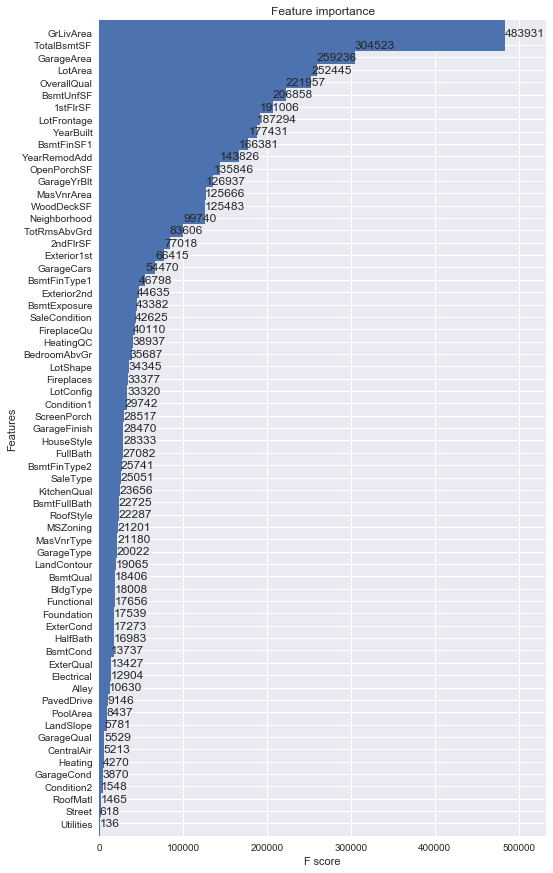

In [25]:
plt.figure();
fig, axx = plt.subplots(1, 1, figsize=(8, 15))
xgb.plot_importance(partial_model,  height=3, ax=axx)
plt.show();

## Ensembling the models together and getting the csv output.

In [26]:
answer=preds*0.8+y_pred*0.2
output = pd.DataFrame({'Id': IDs, 'SalePrice': answer})
output.to_csv('Stacked_answer.csv', index=False)
output.head()

,Id,SalePrice
0,1461,120512.690134
1,1462,154326.818870
2,1463,185090.362194
3,1464,189588.975963
4,1465,192316.643488
